<img src="https://raw.githubusercontent.com/hectormelo/Machine-Learning-Techniques/main/Banner.png" ><br>
# Machine Learning Techniques - MISIS4219

Primer semestre - 2024



# **Taller 2**

GeoAlpes, una empresa líder en análisis geoespacial, está buscando mejorar sus técnicas de clasificación automática de imágenes satelitales. El objetivo es poder categorizar distintas características geográficas (como bosques, zonas industriales, zonas de cultivos permanentes, zonas residenciales y rios) con alta precisión y rapidez. Para lograrlo, están interesados en explorar las capacidades de los métodos ensemble.

1.  Exploración y Preparación de Datos

    -   Discuta las particularidades de las imágenes satelitales y sugiera técnicas extra de preprocesamiento de ser necesario.

2.  Implementación de Gradient Boosting

    -   Utilice Gradient Boosting como modelo base. Discuta las ventajas y desafíos de este método, y cómo afecta la precisión y robustez del clasificador. Además, compare el desempeño de Gradient Boosting con el modelo Random Forest presentado en la práctica, ¿logra observar mejoras significativas?

3. Implementación de un nuevo metodo Ensemble
    - Elija y presente un método ensemble de su preferencia.Introduzca y discuta el concepto del método elegido y cómo podría ser benéfico para la clasificación de imágenes satelitales.
    - Compare el desempeño de su método elegido con Gradient Boosting y el modelo Random Forest. Discuta las ventajas y desventajas de cada uno.

4.  Optimización y Ajuste

    -   Realice una búsqueda de los mejores hiperparámetros para mejorar el desempeño de cada uno de los modelos implementados (Grid Search).

Datos: [Enlace al sub conjunto del dataset de imágenes satelitales EuroSAT](https://github.com/hectormelo/Machine-Learning-Techniques/raw/main/Lab_2/EuroSAT3.zip)


# **DESARROLLO TALLER 2:**

* William Ravelo - 201532093
* Jose Moreno    - 201011998


# Paso 0: Importación de librerias relevantes:

In [175]:
import os
import time

import numpy as np

import matplotlib.pyplot as plt

import cv2
import requests

from sklearn.metrics import accuracy_score # Cálculo de la precisión
from sklearn.decomposition import PCA # Análisis de componentes principales

from sklearn.ensemble import GradientBoostingClassifier  # Libreria para el modelo de Gradient Boosting
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import time

from sklearn.model_selection import train_test_split # División de datos en entrenamiento y prueba
from sklearn.model_selection import GridSearchCV # Búsqueda de hiperparámetros

from sklearn.preprocessing import StandardScaler # Estandarización de datos

from sklearn.metrics import classification_report, accuracy_score # Reporte de clasificación y precisión
from sklearn.svm import SVC # Máquina de soporte vectorial
from sklearn.ensemble import RandomForestClassifier #Librería para manejo del algoritmo Random Forest

from PIL import Image #Librería para brir, manipular y guardar muchos formatos diferentes de archivos de imágenes.

from skimage import io
from zipfile import ZipFile
from io import BytesIO


# Paso 1: Carga + exploración + preprocesamiento de los datos:

In [176]:
# RUTA de los datos:
#path='https://github.com/JoseMoCa/ML_techniques/blob/1805eaf96ea7c5b8cea010ec2dff4496a02e9cfc/TALLER_2/content/EuroSAT3'
path='/Users/josemorenoc/PycharmProjects/ML_techniques/TALLER_2/content/EuroSAT3'

# Proceso para cambiar el espacio de color, al estandar más usado RGB:

def load_image(folder):
    img, y = [], []
    
    for file in os.listdir(folder):
        path = os.path.join(folder, file)
        for i in os.listdir(path):
            # Read image using OpenCV
            image = cv2.imread(os.path.join(path, i), cv2.IMREAD_COLOR)
            # Pass image from BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # Resize image while preserving the number of channels

            # se re-ajustan dimensiones de la imagen para hacer pruebas:
            size=64*2        
            image = cv2.resize(image, (size, size))
            
            img.append(image)
            y.append(file)

    return np.array(img), np.array(y)

# Proceso para cambiar el espacio de color al estandar más usado RGB + aplicar filtro (Gaussiano o Detección de Bordes):
def load_image_F(folder):
    img, y = [], []
    
    for file in os.listdir(folder):
        path = os.path.join(folder, file)
        for i in os.listdir(path):
            # Read image using OpenCV
            image = cv2.imread(os.path.join(path, i), cv2.IMREAD_COLOR)
            # Pass image from BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # Resize image while preserving the number of channels

            # se re-ajustan dimensiones de la imagen para hacer pruebas y se usa interpolación:
            size=64*2
            image = cv2.resize(image, (size, size), interpolation=cv2.INTER_CUBIC)

            # Se propone un filtrado de imágenes, lo cual resulta útil para reducir el ruido, mejorar la nitidez.
            # Se usará el filtro Gaussiano, que suaviza la imagen:
            image_f = cv2.GaussianBlur(image, (5, 5), 0)

            # Si se aplica la detección de bordes "Canny", primero pasando a espacio de color de grises:
            image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Ajustar los umbrales de Canny basándose en las características de la imagen
            sigma = 0.25
            v = np.median(image_gray)
            lower = int(max(0, (1.0 - sigma) * v))
            upper = int(min(255, (1.0 + sigma) * v))
            image_b = cv2.Canny(image_gray, lower, upper)

            image_b = cv2.convertScaleAbs(image_b) # se convierte la imagen de bordes a la misma profundidad que la imagen suavizada para poder sumarlas
            
            # Convertir la imagen de bordes (escala de grises) a una imagen de 3 canales para poder sumarla con image_f
            image_b_rgb = cv2.cvtColor(image_b, cv2.COLOR_GRAY2RGB)

            # se agregan o combinan las imágenes utilizando método de fusión:
            alpha = 0.5  # parámetro de ajuste
            imagen_comb = cv2.addWeighted(image_f, alpha, image_b_rgb, 1 - alpha, 0)
            
            img.append(imagen_comb)
            y.append(file)

    return np.array(img), np.array(y)



In [177]:
#cargamos las imágenes que se encuentran en EuroSAT, tanto originales como las filtradas
X, y = load_image(path)
X_f, y_f = load_image_F(path)

#Partimos el conjunto de datos en un conjunto de entrenamiento (80%) y otro de test (20%), tanto originales como las filtradas
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

x_train_f, x_test_f, y_train_f, y_test_f = train_test_split(X_f, y_f, test_size=0.2, random_state=42)


In [178]:
# Tamaño de los datos
X.shape
X_f.shape

(3750, 128, 128, 3)

In [179]:
x_test.shape
x_test_f.shape

(750, 128, 128, 3)

In [180]:
y.shape
y_f.shape

(3750,)

In [181]:
y_test.shape
y_test_f.shape

(750,)

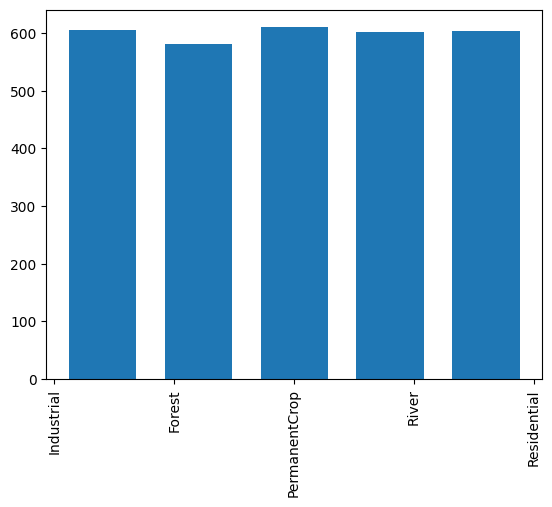

In [182]:
# Observar distribución de clases
plt.hist(y_train, bins=5, rwidth=0.7)
plt.xticks(rotation='vertical')
plt.show()


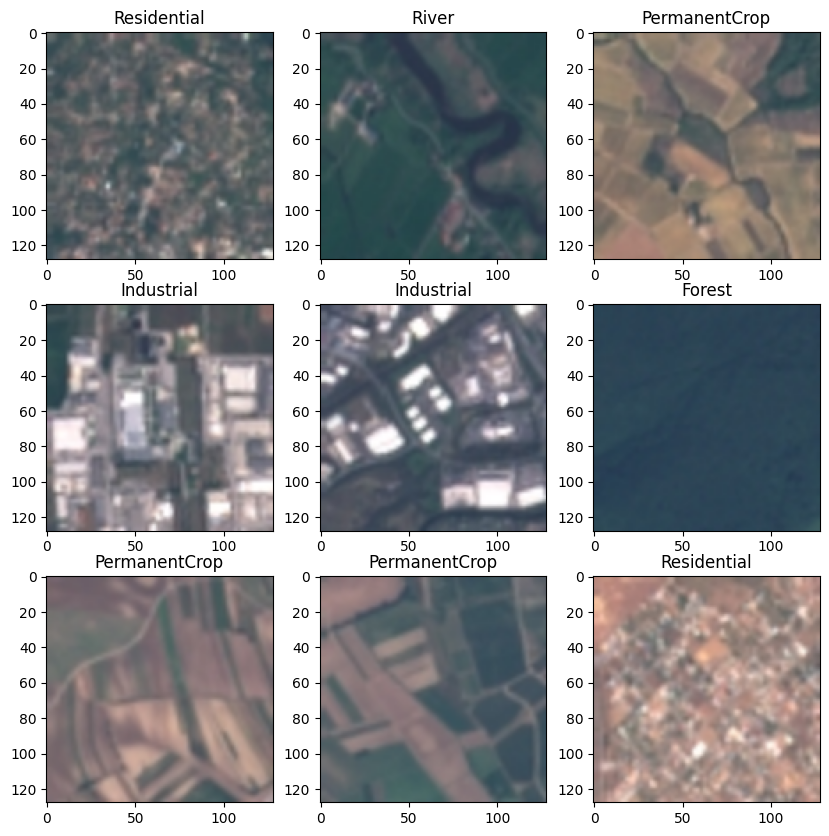

In [183]:
# Visualizar un subconjunto de las imagenes

plt.figure(figsize=(10,10))
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    rdn = np.random.randint(0, len(x_train))
    plt.imshow(x_train[rdn])
    plt.title(y_train[rdn])


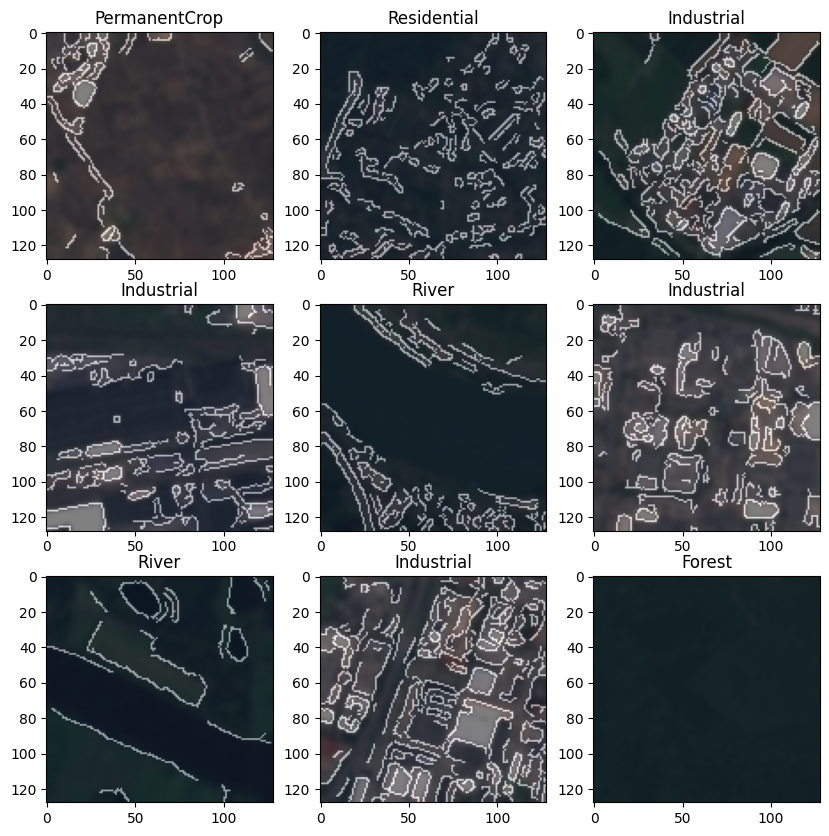

In [184]:
# Visualizar un subconjunto de las imagenes con filtrado

plt.figure(figsize=(10,10))
for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    rdn = np.random.randint(0, len(x_train_f))
    plt.imshow(x_train_f[rdn])
    plt.title(y_train_f[rdn])

In [185]:
# Observar la distribución de los labels
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)
# Para imprimir cada par clave-valor en una línea nueva de los valores de entrenaimento
print("Distribución de los labels de entrenamiento: ")
dic_entrenamiento=  dict(zip(unique_train, counts_train))
for clave, valor in dic_entrenamiento.items():
    print(f'{clave}: {valor}')
# Para imprimir cada par clave-valor en una línea nueva de los valores de test
print("\nDistribución de los labels de test: ")
dic_test= dict(zip(unique_test, counts_test))
for clave, valor in dic_test.items():
    print(f'{clave}: {valor}')

Distribución de los labels de entrenamiento: 
Forest: 581
Industrial: 605
PermanentCrop: 610
Residential: 603
River: 601

Distribución de los labels de test: 
Forest: 169
Industrial: 145
PermanentCrop: 140
Residential: 147
River: 149


# Paso 2: Preparación de los datos para el algoritmo:

In [186]:
# Se trabajaron con los 2 sets de información para contratastar resultados entre imagenes con primer procesamiento,
# frente a las imagenes filtradas.

# Estandarizacion: Con este paso se logra tener variables con media cero y con varianza 1.

# Convertir imágenes a vectores 1D
x_train_reshaped = x_train.reshape(x_train.shape[0], -1)
x_test_reshaped = x_test.reshape(x_test.shape[0], -1)

# Estandarizar las imágenes
scaler = StandardScaler().fit(x_train_reshaped)
x_train_standard = scaler.transform(x_train_reshaped)
x_test_standard = scaler.transform(x_test_reshaped)

In [187]:
# PCA: con esta transformación se logran nuevas variables que capturan un % predeterminado de varianza total.

# Conservar el 90% de la varianza; donde se selecciona 90% para tener menos variables que procesar e igual un alto poder explicativo.
pca = PCA(0.90).fit(x_train_standard)
x_train_pca = pca.transform(x_train_standard)
x_test_pca = pca.transform(x_test_standard)

# Informativo: Dimensionalidad de los datos sin PCA
x_train_standard.shape

(3000, 49152)

In [188]:
# Numero de componentes principales
print(f"El número de componente principales que conservan el 90% de la varianza es: {pca.n_components_}")

# Dimensionalidad de los datos con PCA
x_train_pca.shape

El número de componente principales que conservan el 90% de la varianza es: 123


(3000, 123)

Por tanto, para la muestra inicial de imagenes, se tendrían que procesar unas 49.152 variables;
sin embargo gracias a la transformación de PCA, se logra explicar el 90% de la varianza de la muestra con unas 123 variables.


# Paso 3: Algortimo de Clasificación Gradient Boosting como modelo base

El algoritmo de clasificación de  Random Forest es un método de aprendizaje en conjunto (ensemble learning) que opera construyendo múltiples árboles de decisión durante el entrenamiento y produciendo la clase que es la moda de las clasificaciones (para problemas de clasificación) o la media de las predicciones (para problemas de regresión) de los árboles individuales. Random Forest corrige la tendencia de los árboles de decisión a sobreajustarse a su conjunto de entrenamiento, proporcionando un resultado más generalizado y robusto.

El Gradient Boosting es una técnica utilizada para problemas de regresión y clasificación, que produce un modelo de predicción en forma de un ensamble de modelos predictivos más sencillos, generalmente se usan arboles de decisión. 

El algoritmo funciona construyendo de forma iterativa modelos adicionales que corrigen los errores cometidos por las versiones anteriores combinadas. Para efectos de nuestro ejercicio de clasificación de imagenes, el Gradient Boosting aprenderá y mejorará iterativamente a partir de las características que obtiene de las imágenes, ajustándose para minimizar un criterio de pérdida y mejorar la precisión de la clasificación en cada iteración. 

Si se compara el Gradient Boosting con el de Random Forest, se pueden plantear pros y contras: 

** Pros de Gradient Boosting ** 
(1) tendría mejor capacidad predictiva por su enfoque iterativo y adaptativo para minimizar errores
(2) Es flexible con respecto a la función de pérdida y, por lo tanto, puede ser más afinado para problemas específicos. 

** Contras de Gradient Boosting ** 
(1) Puede ser más susceptible al sobreajuste, especialmente con datos ruidosos o en situaciones con una cantidad limitada de datos
(2) Puede ser más lento para entrenar que el Random Forest debido a su naturaleza iterativa y secuencial, no paralelizable, lo cual ante un conjunto con muchas imagenes puede tomar demasiado tiempo. Por otro lado, Random Forest es más fácil de paralelizar y puede ser más robusto al sobreajuste.



# Paso 3.1: Clasificación Gradient Boosting para MUESTRA con PREPROCESAMIENTO BASICO (original + BGR2RGB)

In [190]:
# Crear un clasificador de Gradient Boosting con un máximo de X iteraciones (n_estimators=X)
clasificador_gb = GradientBoostingClassifier(n_estimators=50, random_state=0)

# Entrenar el clasificador con los datos de entrenamiento 
start = time.time()
clasificador_gb.fit(x_train_pca, y_train)
# Tiempo de entrenamiento
end = time.time()
print(f"Tiempo de entrenamiento con Gradient Boosting: {end - start}")

# Realizar predicciones en los datos de prueba
y_pred_gb = clasificador_gb.predict(x_test_pca)

# Precisión
print("Precisión de Gradient Boosting:", accuracy_score(y_test, y_pred_gb),', con un número de iteraciones de 50')


Tiempo de entrenamiento con Gradient Boosting: 25.21713376045227
Precisión de Gradient Boosting: 0.832 , con un número de iteraciones de 50


In [191]:
# Crear un clasificador de Gradient Boosting con un máximo de X iteraciones (n_estimators=X)
clasificador_gb = GradientBoostingClassifier(n_estimators=100, random_state=0)

# Entrenar el clasificador con los datos de entrenamiento 
start = time.time()
clasificador_gb.fit(x_train_pca, y_train)
# Tiempo de entrenamiento
end = time.time()
print(f"Tiempo de entrenamiento con Gradient Boosting: {end - start}")

# Realizar predicciones en los datos de prueba
y_pred_gb = clasificador_gb.predict(x_test_pca)


Tiempo de entrenamiento con Gradient Boosting: 49.80610680580139


In [192]:
# Precisión
print("Precisión de Gradient Boosting:", accuracy_score(y_test, y_pred_gb),', con un número de iteraciones de 100')
print("Forma Test: ",y_test.shape,' Forma Pres:',y_pred_gb.shape)

Precisión de Gradient Boosting: 0.8453333333333334 , con un número de iteraciones de 100
Forma Test:  (750,)  Forma Pres: (750,)



Informe de clasificación de Gradient Boosting:
               precision    recall  f1-score   support

       Forest       0.93      0.96      0.94       169
   Industrial       0.90      0.91      0.90       145
PermanentCrop       0.78      0.79      0.79       140
  Residential       0.79      0.77      0.78       147
        River       0.81      0.77      0.79       149

     accuracy                           0.85       750
    macro avg       0.84      0.84      0.84       750
 weighted avg       0.84      0.85      0.84       750


Matriz de confusión de Gradient Boosting:


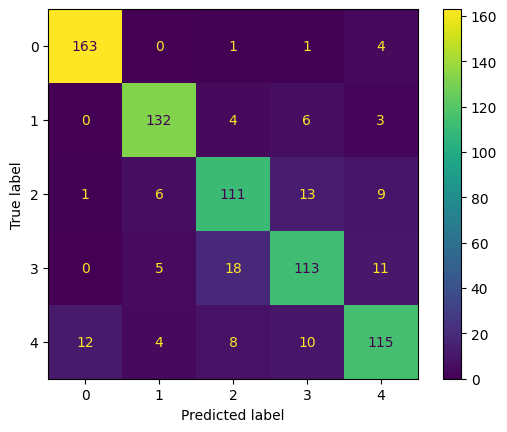

In [193]:
# Informe de clasificación
print("\nInforme de clasificación de Gradient Boosting:")
print(classification_report(y_test, y_pred_gb))

# Matriz de confusión
print("\nMatriz de confusión de Gradient Boosting:")
cm_gb = confusion_matrix(y_test, y_pred_gb)
disp_gb = ConfusionMatrixDisplay(confusion_matrix=cm_gb)
disp_gb.plot()

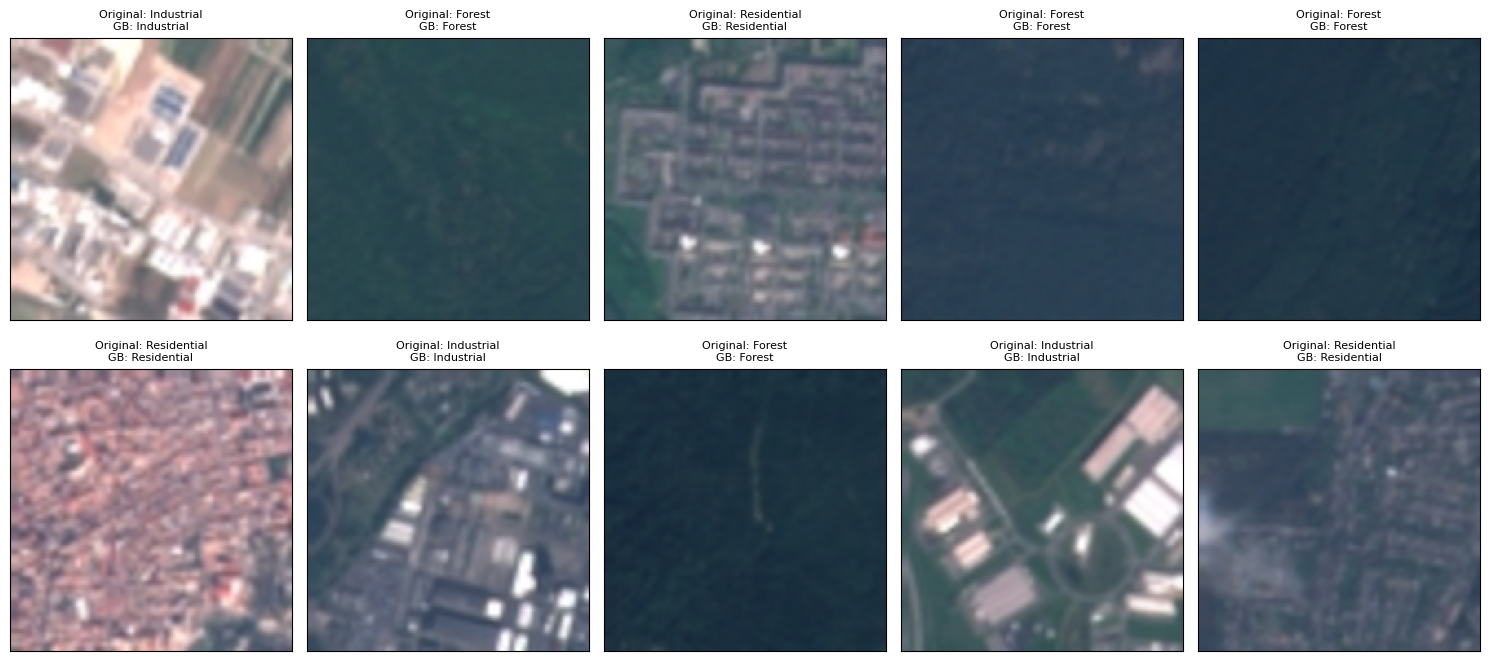

In [194]:
# Seleccionar 10 imágenes aleatorias
indices = np.random.choice(range(len(x_test)), size=10, replace=False)

# Crear una figura con 10 subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 7))

# Iterar sobre las 10 imágenes seleccionadas
for i, index in enumerate(indices):
    # Obtener la imagen y la etiqueta real
    image = x_test[index]
    true_label = y_test[index]

    # Predecir la etiqueta usando RandomForest
    predicted_label_gb = clasificador_gb.predict([x_test_pca[index]])

    # Mostrar la imagen
    axes[i // 5, i % 5].imshow(image, cmap='gray')
    # Establecer el título con la etiqueta original, la predicción de Gradient Boosting
    axes[i // 5, i % 5].set_title(f"Original: {true_label}\nGB: {predicted_label_gb[0]}", fontsize=8)
    axes[i // 5, i % 5].set_xticks([])
    axes[i // 5, i % 5].set_yticks([])

# Mostrar la figura
plt.tight_layout()
plt.show()

# Paso 3.2: Clasificación Gradient Boosting MUESTRA con PREPROCESAMIENTO FILTRADO y BORDES (original + FiltGauss + CANNY)

In [195]:
# Se trabajaron con los 2 sets de información para contratastar resultados entre imagenes con primer procesamiento,
# frente a las imagenes filtradas.

# Estandarizacion: Con este paso se logra tener variables con media cero y con varianza 1.

# Convertir imágenes a vectores 1D
x_train_reshaped_f = x_train_f.reshape(x_train_f.shape[0], -1)
x_test_reshaped_f = x_test_f.reshape(x_test_f.shape[0], -1)

# Estandarizar las imágenes
scaler_f = StandardScaler().fit(x_train_reshaped_f)
x_train_standard_f = scaler_f.transform(x_train_reshaped_f)
x_test_standard_f = scaler_f.transform(x_test_reshaped_f)

# Creación de un clasificador de Gradient Boosting:

# Crear un clasificador de Gradient Boosting con un máximo de X iteraciones (n_estimators=X)
clasificador_gb_f = GradientBoostingClassifier(n_estimators=100, random_state=0)

# PCA: con esta transformación se logran nuevas variables que capturan un % predeterminado de varianza total.

# Conservar el 90% de la varianza; donde se selecciona 90% para tener menos variables que procesar e igual un alto poder explicativo.
pca_f = PCA(0.90).fit(x_train_standard_f)
x_train_pca_f = pca_f.transform(x_train_standard_f)
x_test_pca_f = pca_f.transform(x_test_standard_f)

# Informativo: Dimensionalidad de los datos sin PCA
x_train_standard_f.shape

(3000, 49152)

In [196]:
# Numero de componentes principales
print(f"PARA MUESTRA IMAGEN FILTRADAS: El número de CP que conservan el 90% de la varianza es: {pca_f.n_components_}")

# Dimensionalidad de los datos con PCA
x_train_pca_f.shape

PARA MUESTRA IMAGEN FILTRADAS: El número de CP que conservan el 90% de la varianza es: 1332


(3000, 1332)

In [197]:
# Entrenar el clasificador con los datos de entrenamiento 
start = time.time()
clasificador_gb_f.fit(x_train_pca_f, y_train_f)
# Tiempo de entrenamiento
end = time.time()
print(f"Tiempo de entrenamiento con Gradient Boosting: {end - start}")

Tiempo de entrenamiento con Gradient Boosting: 539.6957340240479


In [198]:
# Realizar predicciones en los datos de prueba
y_pred_gb_f = clasificador_gb_f.predict(x_test_pca_f)
x_train_pca_f.shape

(3000, 1332)

In [199]:
# Precisión
y_test_f.shape
y_pred_gb_f.shape
print("Forma Test: ",y_test_f.shape,' Forma Pres:',y_pred_gb_f.shape)

Forma Test:  (750,)  Forma Pres: (750,)


In [200]:
print("Precisión de Gradient Boosting:", accuracy_score(y_test_f, y_pred_gb_f),', con un número de iteraciones de 100')

Precisión de Gradient Boosting: 0.812 , con un número de iteraciones de 100



Informe de clasificación de Gradient Boosting:
               precision    recall  f1-score   support

       Forest       0.94      0.98      0.96       169
   Industrial       0.79      0.88      0.83       145
PermanentCrop       0.79      0.79      0.79       140
  Residential       0.84      0.55      0.66       147
        River       0.71      0.85      0.77       149

     accuracy                           0.81       750
    macro avg       0.81      0.81      0.80       750
 weighted avg       0.82      0.81      0.81       750


Matriz de confusión de Gradient Boosting:


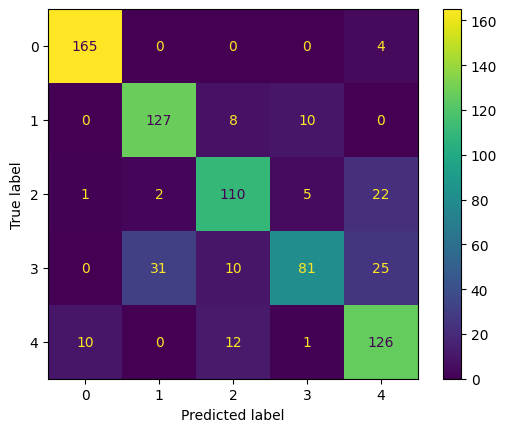

In [201]:
# Informe de clasificación
print("\nInforme de clasificación de Gradient Boosting:")
print(classification_report(y_test_f, y_pred_gb_f))

# Matriz de confusión
print("\nMatriz de confusión de Gradient Boosting:")
cm_gb_f = confusion_matrix(y_test_f, y_pred_gb_f)
disp_gb = ConfusionMatrixDisplay(confusion_matrix=cm_gb_f)
disp_gb.plot()

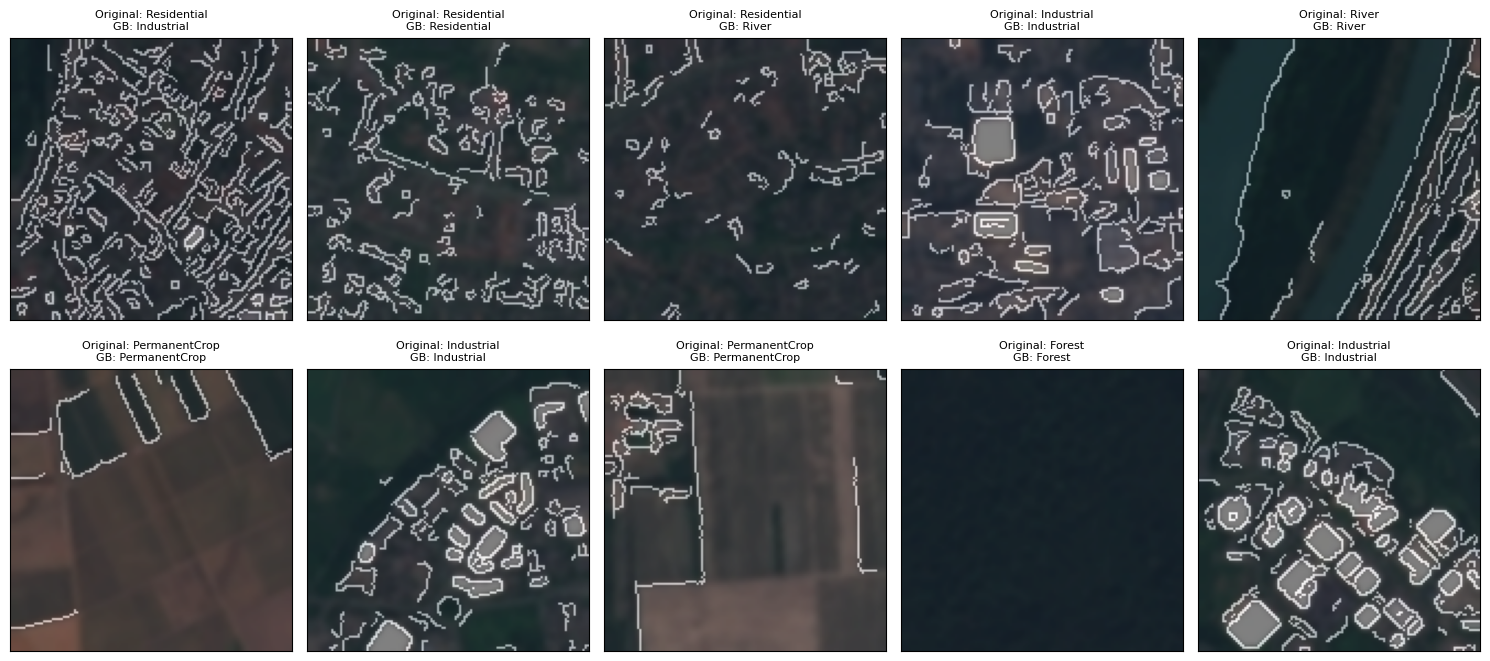

In [202]:
# Seleccionar 10 imágenes aleatorias
indices = np.random.choice(range(len(x_test_f)), size=10, replace=False)

# Crear una figura con 10 subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 7))

# Iterar sobre las 10 imágenes seleccionadas
for i, index in enumerate(indices):
    # Obtener la imagen y la etiqueta real
    image = x_test_f[index]
    true_label = y_test_f[index]

    # Predecir la etiqueta usando RandomForest
    predicted_label_gb_f = clasificador_gb_f.predict([x_test_pca_f[index]])

    # Mostrar la imagen
    axes[i // 5, i % 5].imshow(image, cmap='gray')
    # Establecer el título con la etiqueta original, la predicción de Gradient Boosting
    axes[i // 5, i % 5].set_title(f"Original: {true_label}\nGB: {predicted_label_gb_f[0]}", fontsize=8)
    axes[i // 5, i % 5].set_xticks([])
    axes[i // 5, i % 5].set_yticks([])

# Mostrar la figura
plt.tight_layout()
plt.show()

# Paso 3.3. Resultados del ejercicio comparativo

En este punto, se compararán entonces 3 tipos de modelos evaluados:

A) Modelo de RandomForest - Laboratorio 2.
B) Modelo de Gradient Boosting, con dataset preprocesado de forma básica Reescalamiento - Taller 2
C) Modelo de GRadient Boosting, con dataset preprocesado con Reescalamiento+Suavizamiento+Detección Bordes - Taller 2.

Los resultados del algoritmo de Gradient Boosting, con procesamiento básico, fueron mejores frente a los demás modelos evaluados. En todo caso, incluso el modelo C), fue mejor que el modelo evaluado en laaboratorio 2, es decir que el modelo A).

A) Modelo de RandomForest - Precisión 80.1% 
B) Modelo de Gradient Boosting - Precisión básico 84.5% 
C) Modelo de GRadient Boosting - Preproc avanzado - Precisión 81.2% 


# Paso 4. Implementación de un nuevo metodo Ensemble

* revisando la naturaleza y tipo de uso de otros metodos ENSEMBLE, como lo pueden ser: Histogram Based Gradient Boosting, Voting Classifier, Voting Regressor o Stacked generalization, evaluaremos el desempeño del modelo: "Stacked Generalization", mediante la siguiente implementación:

* Usaremos el dataset de las imagenes con preprocesamiento inicial
* Se seleccionan unos modelos BASE
* Se selecciona el meta-modelo, el cual al final, realizará la predicción:


# Paso 4.1 Método Ensemble con Stacked generalization - Para muestra con Preprocesamiento Básico:


Tiempo de entrenamiento con Stacked Generalization (Gradient Boosting): 24.757104873657227
Precisión de Stacked Generalization (Gradient Boosting): 0.884

Informe de clasificación de Stacked Generalization (Gradient Boosting):
               precision    recall  f1-score   support

       Forest       0.96      0.98      0.97       169
   Industrial       0.92      0.94      0.93       145
PermanentCrop       0.83      0.85      0.84       140
  Residential       0.81      0.80      0.80       147
        River       0.87      0.84      0.86       149

     accuracy                           0.88       750
    macro avg       0.88      0.88      0.88       750
 weighted avg       0.88      0.88      0.88       750


Matriz de confusión de Stacked Generalization (Gradient Boosting):


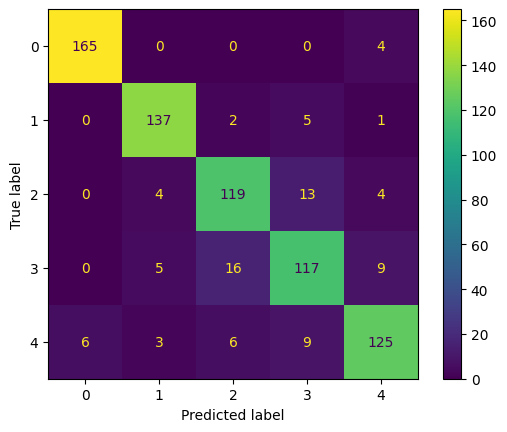

In [204]:
# Se importan librerias faltantes, y otras para hacer pruebas:

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Definición de Modelos base
modelos_base = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svc', SVC(probability=True, random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42))
]

# Meta-modelo_: Gradient Boosting
meta_modelo_gbN = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Crear el clasificador de Stacking con Gradient Boosting como meta-modelo
clasificador_stacking_gbN = StackingClassifier(estimators=modelos_base, final_estimator=meta_modelo_gbN, cv=5)

# Entrenar el clasificador de Stacking con los datos de entrenamiento
start = time.time()
clasificador_stacking_gbN.fit(x_train_pca, y_train)
end = time.time()
print(f"Tiempo de entrenamiento con Stacked Generalization (Gradient Boosting): {end - start}")

# Realizar predicciones en los datos de prueba con el clasificador de Stacking
y_pred_stacking_gbN = clasificador_stacking_gbN.predict(x_test_pca)

# Precisión
print("Precisión de Stacked Generalization (Gradient Boosting):", accuracy_score(y_test, y_pred_stacking_gbN))

# Informe de clasificación
print("\nInforme de clasificación de Stacked Generalization (Gradient Boosting):")
print(classification_report(y_test, y_pred_stacking_gbN))

# Matriz de confusión
print("\nMatriz de confusión de Stacked Generalization (Gradient Boosting):")
cm_stacking_gbN = confusion_matrix(y_test, y_pred_stacking_gbN)
disp_stacking_gbN = ConfusionMatrixDisplay(confusion_matrix=cm_stacking_gbN)
disp_stacking_gbN.plot()

# Paso 4.2 Método Ensemble con Stacked generalization - Para muestra con Preprocesamiento Avanzado:


Tiempo de entrenamiento con Stacked Generalization (Gradient Boosting) - Imagenes Filtradas: 110.22006893157959
Precisión de Stacked Generalization - Imagenes Filtradas (Gradient Boosting): 0.6333333333333333

Informe de clasificación de Stacked Generalization - Imagenes Filtradas (Gradient Boosting):
               precision    recall  f1-score   support

       Forest       0.97      0.98      0.98       169
   Industrial       0.88      0.32      0.47       145
PermanentCrop       0.37      0.86      0.51       140
  Residential       0.63      0.13      0.21       147
        River       0.74      0.83      0.78       149

     accuracy                           0.63       750
    macro avg       0.72      0.62      0.59       750
 weighted avg       0.73      0.63      0.60       750


Matriz de confusión de Stacked Generalization - Imagenes Filtradas (Gradient Boosting):


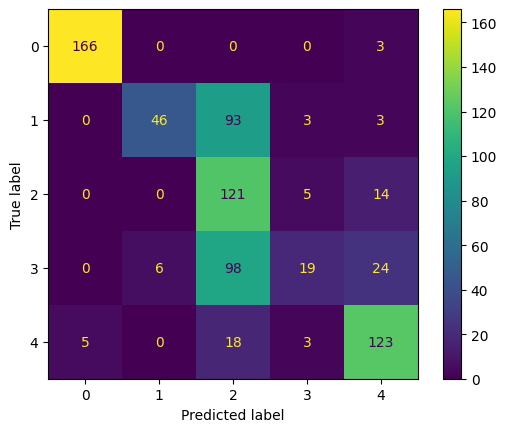

In [205]:
# Meta-modelo_: Gradient Boosting
meta_modelo_gbN_f = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Crear el clasificador de Stacking con Gradient Boosting como meta-modelo
clasificador_stacking_gbN_f = StackingClassifier(estimators=modelos_base, final_estimator=meta_modelo_gbN_f, cv=5)

# Entrenar el clasificador de Stacking con los datos de entrenamiento
start = time.time()
clasificador_stacking_gbN_f.fit(x_train_pca_f, y_train_f)
end = time.time()
print(f"Tiempo de entrenamiento con Stacked Generalization (Gradient Boosting) - Imagenes Filtradas: {end - start}")

# Realizar predicciones en los datos de prueba con el clasificador de Stacking
y_pred_stacking_gbN_f = clasificador_stacking_gbN_f.predict(x_test_pca_f)

# Precisión
print("Precisión de Stacked Generalization - Imagenes Filtradas (Gradient Boosting):", accuracy_score(y_test_f, y_pred_stacking_gbN_f))

# Informe de clasificación
print("\nInforme de clasificación de Stacked Generalization - Imagenes Filtradas (Gradient Boosting):")
print(classification_report(y_test_f, y_pred_stacking_gbN_f))

# Matriz de confusión
print("\nMatriz de confusión de Stacked Generalization - Imagenes Filtradas (Gradient Boosting):")
cm_stacking_gbN_f = confusion_matrix(y_test_f, y_pred_stacking_gbN_f)
disp_stacking_gbN_f = ConfusionMatrixDisplay(confusion_matrix=cm_stacking_gbN_f)
disp_stacking_gbN_f.plot()

# Paso 5. Optimización y Ajuste de Modelos - Busqueda de Hiperparámetros


Para efectos de este ultimo paso, consideraremos los siguientes modelos para la busqueda de sus respectivos hiperparámetros:

A) Gradient Boosting para MUESTRA con PREPROCESAMIENTO BASICO
B) Método Ensemble con Stacked generalization con PREPROCESAMIENTO BASICO


# Paso 5.1. Optimización de Hiperparámetros para Modelo A) Gradient Boosting para MUESTRA con PREPROCESAMIENTO BASICO


In [212]:
# Optimización de Hiperparámetros para Modelo A) Gradient Boosting para MUESTRA con PREPROCESAMIENTO BASICO

# importación de librerias faltantes o relevantes:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Definir el pipeline
pipeline = Pipeline([
    ('clf', GradientBoostingClassifier(random_state=0))
])

# Definir los hiperparámetros para probar
param_grid = {
    'clf__n_estimators': [50, 100],  # Número de iteraciones
    'clf__learning_rate': [1.0],  # Tasa de aprendizaje
    'clf__max_depth': [2, 3]  # Profundidad máxima de los árboles
}

# Configurar GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
# con n_jobs=-1, se utilizan todas las CPUs disponibles para paralelizar los trabajos de optimización


# Entrenar GridSearchCV con los datos de entrenamiento aplanados
start = time.time()
grid_search.fit(x_train_reshaped, y_train)  # Usar datos aplanados aquí
end = time.time()
print(f"Tiempo de entrenamiento con GridSearchCV: {end - start}")

# Mejores parámetros encontrados
print("Mejores parámetros: ", grid_search.best_params_)

# Mejor puntuación obtenida
print("Mejor puntuación de GridSearchCV: ", grid_search.best_score_)

# Realizar predicciones con el mejor clasificador encontrado en los datos de prueba aplanados
y_pred_optimized = grid_search.predict(x_test_reshaped)  # Usar datos aplanados aquí

# Precisión
print("Precisión del Gradient Boosting optimizado:", accuracy_score(y_test, y_pred_optimized))

# Informe de clasificación
print("\nInforme de clasificación del Gradient Boosting optimizado:")
print(classification_report(y_test, y_pred_optimized))

# Matriz de confusión
print("\nMatriz de confusión del Gradient Boosting optimizado:")
cm_optimized = confusion_matrix(y_test, y_pred_optimized)
disp_optimized = ConfusionMatrixDisplay(confusion_matrix=cm_optimized)
disp_optimized.plot()

Fitting 5 folds for each of 4 candidates, totalling 20 fits


python(52113) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(52114) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(52115) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(52116) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(52117) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(52118) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(52119) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(52120) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


KeyboardInterrupt: 

# Paso 5.2. Optimización de Hiperparámetros para Modelo B) Stacked Generalization para MUESTRA con PREPROCESAMIENTO BASICO


In [ ]:
# Definir modelos base
modelos_base = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('svc', SVC(probability=True, random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42))
]

# Meta-modelo: Gradient Boosting
meta_modelo_gb = GradientBoostingClassifier(random_state=42)

# Crear el clasificador de Stacking
clasificador_stacking = StackingClassifier(estimators=modelos_base, final_estimator=meta_modelo_gb, cv=5)

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'rf__n_estimators': [50, 100],
    'svc__C': [0.1, 1],
    'dt__max_depth': [None, 10],
    'final_estimator__n_estimators': [50, 100],
    'final_estimator__learning_rate': [1.0]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=clasificador_stacking, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

# Entrenar GridSearchCV con los datos de entrenamiento
start = time.time()
grid_search.fit(x_train_pca, y_train)
end = time.time()
print(f"Tiempo de entrenamiento con GridSearchCV: {end - start}")

# Mejores parámetros encontrados
print("Mejores parámetros: ", grid_search.best_params_)

# Mejor puntuación obtenida
print("Mejor puntuación de GridSearchCV: ", grid_search.best_score_)

# Realizar predicciones con el mejor clasificador encontrado
y_pred_optimized = grid_search.predict(x_test_pca)

# Precisión
print("Precisión del modelo optimizado:", accuracy_score(y_test, y_pred_optimized))

# Informe de clasificación
print("\nInforme de clasificación del modelo optimizado:")
print(classification_report(y_test, y_pred_optimized))

# Matriz de confusión
print("\nMatriz de confusión del modelo optimizado:")
cm_optimized = confusion_matrix(y_test, y_pred_optimized)
disp_optimized = ConfusionMatrixDisplay(confusion_matrix=cm_optimized)
disp_optimized.plot()